# Encoders and Decoders

Neural networks can be used to both encode, and decode information. For a simple example of this fact look no further than your own brain. Artificial neural networks can do precisely the same thing. Indeed, a classifier network which has memory is doing precisely this: it takes an image with many pixels and encodes it into a classification label. Encoders/decoders are often given a right/left oriented triangle to denote them. An encoder-decoder may be *lossless* i.e. no information is lost upon decoding. They may also be *lossy* i.e. some information is lost upon decoding. Neural networks typically function as pattern detection machines and therefore they are expected to by *lossy*.


# Autoencoder

A very simple, but useful, MLP architecture is the autoencoder. At its core it is a model which self-encodes vectors i.e. it is the identity function $f(x) = x$. At first glance this might not seem useful *at all*. Given everything we know about neural networks using a large amount of compute to train the simplest possible function seems like a waste of time (it is). However, it can both be incredibly valuable as a space saving tool and it can help us learn labels in a data set in an unsupervised manner.

Consider the human genome with its $10^9$ base pairs and suppose that we have a dataset of 400,000 humans. That is a very large amount of data which would incur substantial costs of storage and read-times when analysing it. We also know there is a large amount of redunancy in the data: mostly the human genome is the same. Therefore, we would like to strip away this redunancy and encode our genomes for storage and create a decoder to reconstruct them when required. This is the identity function mentioned before. The autoencoder has two parts: an encoder $f_{\text{enc}}$ and decoder $f^{\text{dec}}$ obeying the relationship: 

$$f(x) = f^{\text{dec}} \circ f_{\text{enc}} (x) = x$$

They are clearly inverses of each other. We proceed in the normal fashion stating that they are both feed-forward neural networks with the encoder mapping vectors of length $n$ into a latent space of dimension $m$: $f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^m$. The decoder is the reverse $f^{\text{dec}}: \mathbb{R}^m \rightarrow \mathbb{R}^n$. There are several trade-offs to be made: a lower $m$ gives a lower storage size for the latents but requires more layers and thus parameters to train. A higher $m$ requires less parameters but more storage. 

## 1.1 Creating the Network
The first step (and arguably the most important) is to get handle on our data. Machine Learning could equally be described as Machine Teaching - our algorithms are not magical. Data should be inspected, cleaned, and possibly even transformed. Data transformations can be useful for more than just convenience; certain patterns are much easier to learn. Consider trying to find a linear classifier to learn the following data structure:

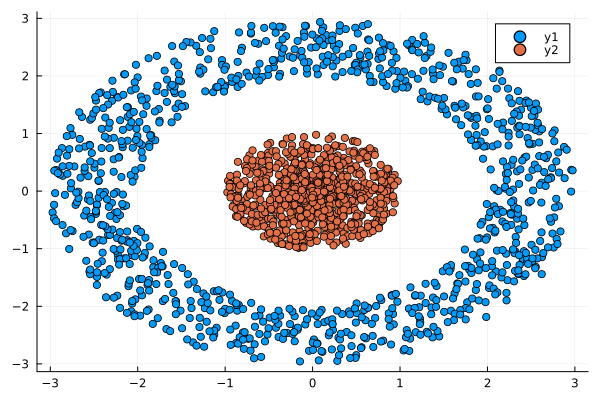

In [1]:
using Plots
s = 1000
rand_sample = [rand(s), s * rand(s), rand(s), s * rand(s)]

data_red = [rand_sample[1].*cos.(rand_sample[2]), rand_sample[1].*sin.(rand_sample[2])]
data_blue = [(2 .+ rand_sample[3]).*cos.(rand_sample[4]), (2 .+ rand_sample[3]).*sin.(rand_sample[4])]
plot(data_blue[1], data_blue[2]; st=scatter)
plot!(data_red[1], data_red[2], st=scatter)

It is fairly clear to see that there is no linear classifier (perceptron) that would partition this data. However, it's also obvious to our eyes that there are distinct classes and it *should* be able to be done. In this case we can perform a simple change of coordinates to reformulate the problem.

In [1]:
data_red_polar = [sqrt.(data_red[1].^2 + data_red[2].^2), atan.(data_red[1] ./ data_red[2])];
data_blue_polar = [sqrt.(data_blue[1].^2 + data_blue[2].^2), atan.(data_blue[1] ./ data_blue[2])];
plot(data_blue_polar[1], data_blue_polar[2]; st=scatter)
plot!(data_red_polar[1], data_red_polar[2], st=scatter)

LoadError: UndefVarError: data_red not defined

This is now a trivial problem and our perceptron would have no difficulty. The take-away message from this toy example is that often the most challenging aspect of a data science problem is deciding how to present the data to the algorithm and this can be also be of the most benefit. Let's import our data now.

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

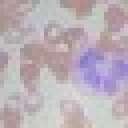
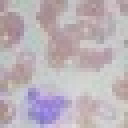
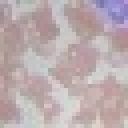
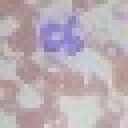
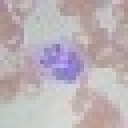
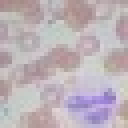
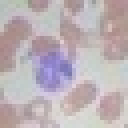
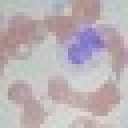
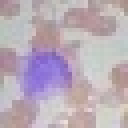
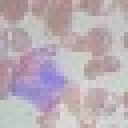
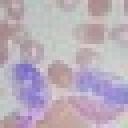
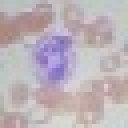
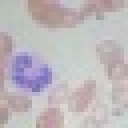
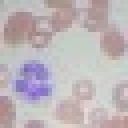
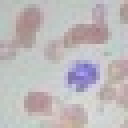
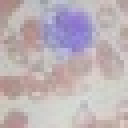
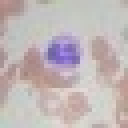
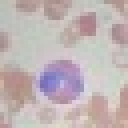
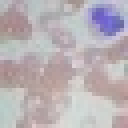
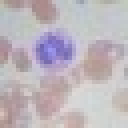
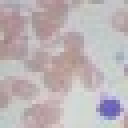
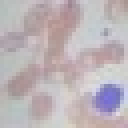
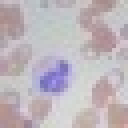
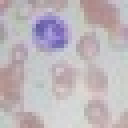
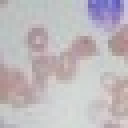
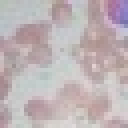
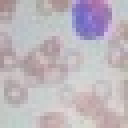
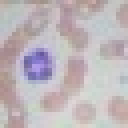
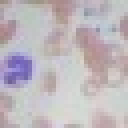
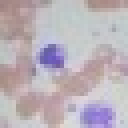
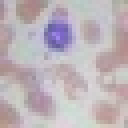
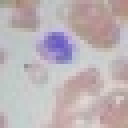
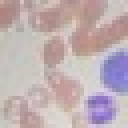
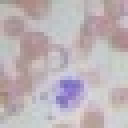
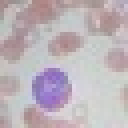
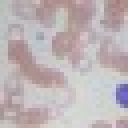
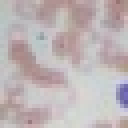
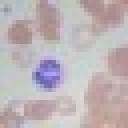
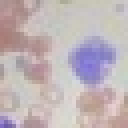
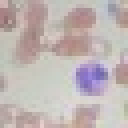
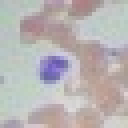
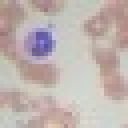
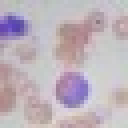
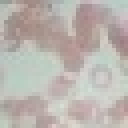
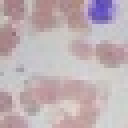
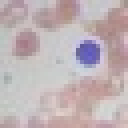
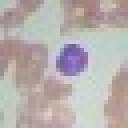
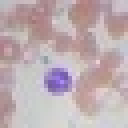
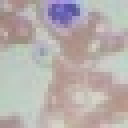
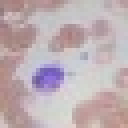
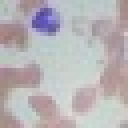
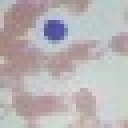
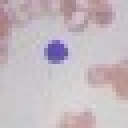
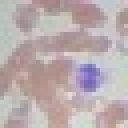
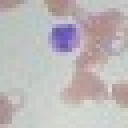
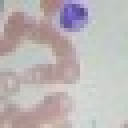
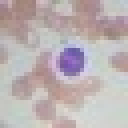
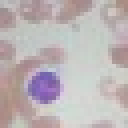
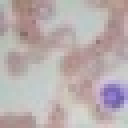
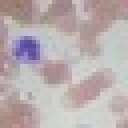
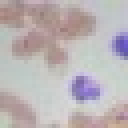
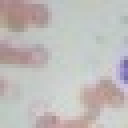
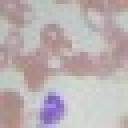
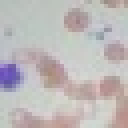
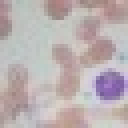
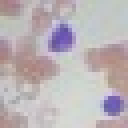
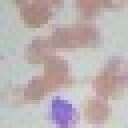
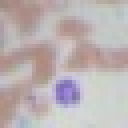
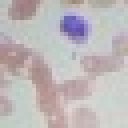
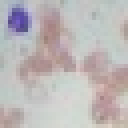
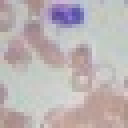
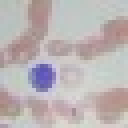
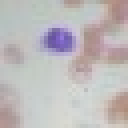
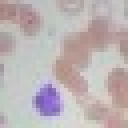
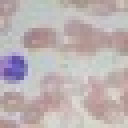
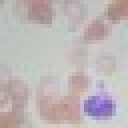
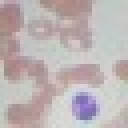
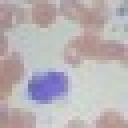
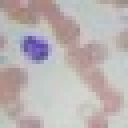
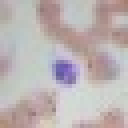
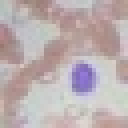
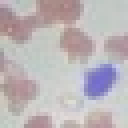
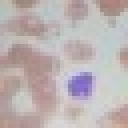
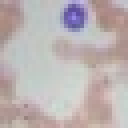
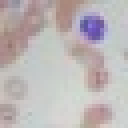
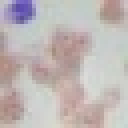
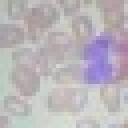
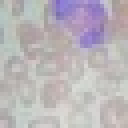
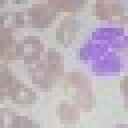
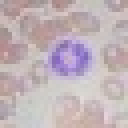
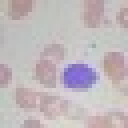
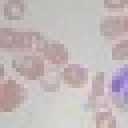
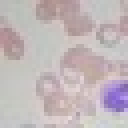
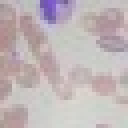
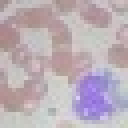
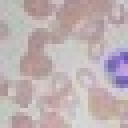
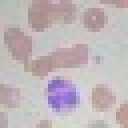
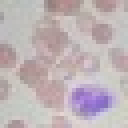
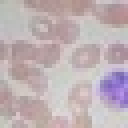
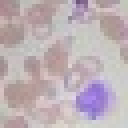
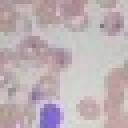
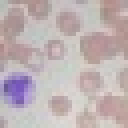
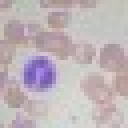
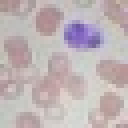
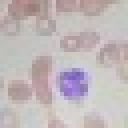
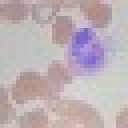
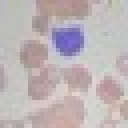
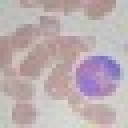
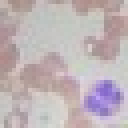
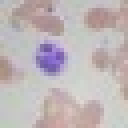
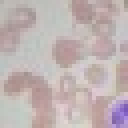
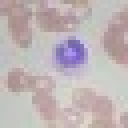
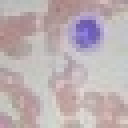
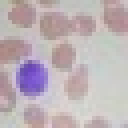
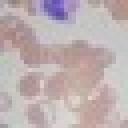
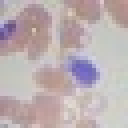
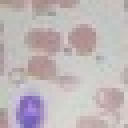
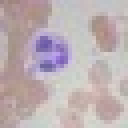
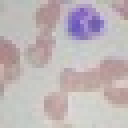
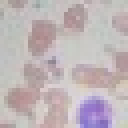
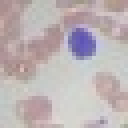
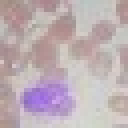
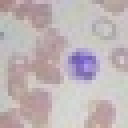
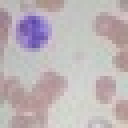
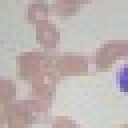
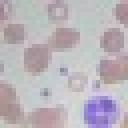
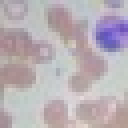
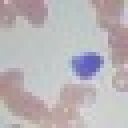
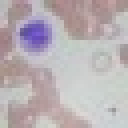
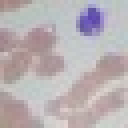
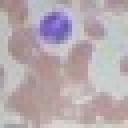
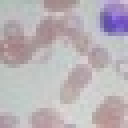
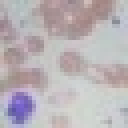
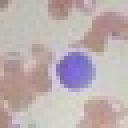
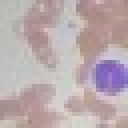
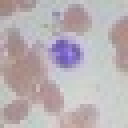
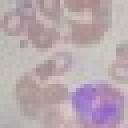
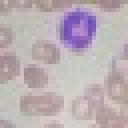
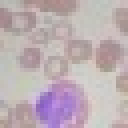
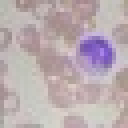
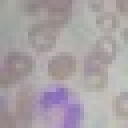
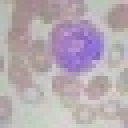
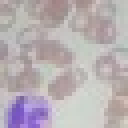
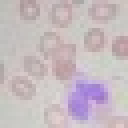
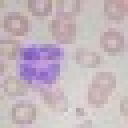
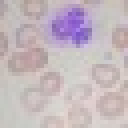
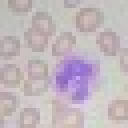
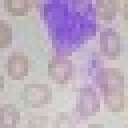
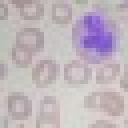
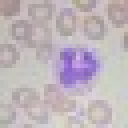
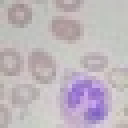
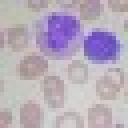
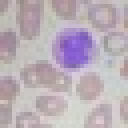
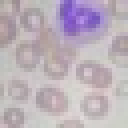
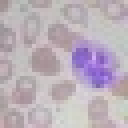
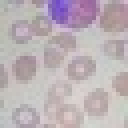
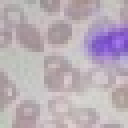
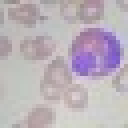
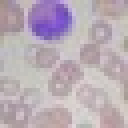
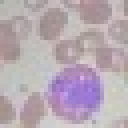
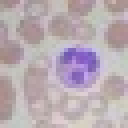
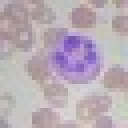
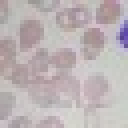
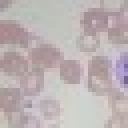
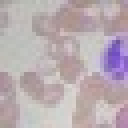
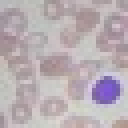
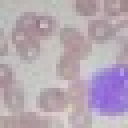
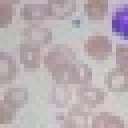
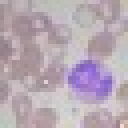
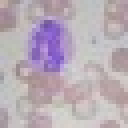
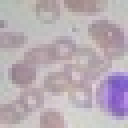
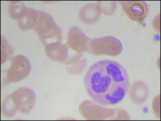
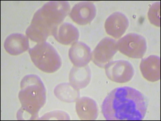
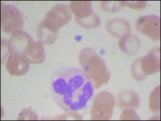
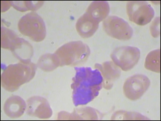
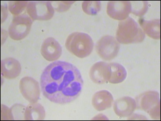
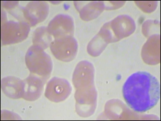
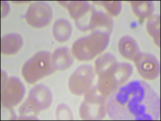
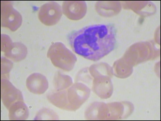
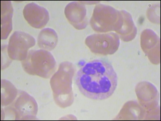
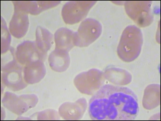
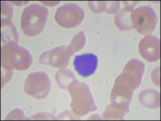
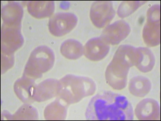
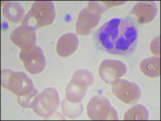
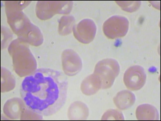
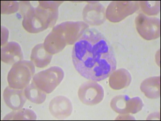
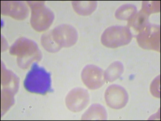
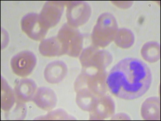
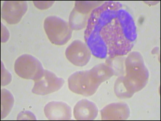
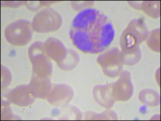
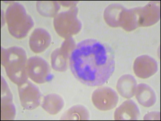
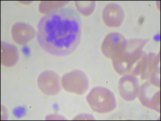
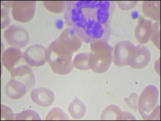
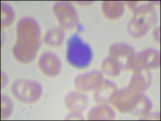
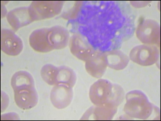
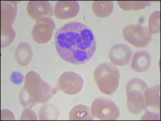
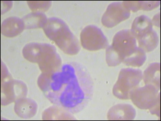
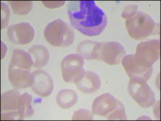
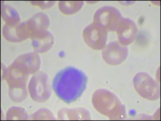
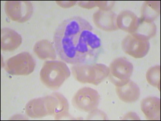

In [3]:
using Images, FileIO
datadirls = readdir("./data/cells"); # find the file names
data_images = [load("./data/cells/" * i) for i in datadirls]

Our data is in the form of RGB images meaning there are three chanels of matrices. We would like this to be a single vector so we will do a simple reshaping routine (which we must remember to undo later!). This is a very simple form of data cleaning and fortunately doesn't require any sophisticated tricks! Fortunately, the data has already been precleaned to a nice manageable size. The original data set is a red blood cell data set and can be found [here](https://github.com/Shenggan/BCCD_Dataset). We will also split our data into test and training sets.

In [44]:
function imgtovec(img)
    imgdimx, imgdimy = size(img)
    vec = Array{Float32, 1}(undef, imgdimx * imgdimy)
    for i in 1:imgdimx
        for j in 1:imgdimy
            idx = ((i-1) * imgdimy + j - 1)
            vec[idx + 1] = Float32(img[i, j].r)
            #vec[idx + 2] = Float32(img[i, j].g)
            #vec[idx + 3] = Float32(img[i, j].b)
        end
    end
    return vec
end

function vectoimg(vec, imgdimx, imgdimy)
    img = Matrix{RGB{Float32}}(undef, imgdimx, imgdimy)
    for i in 1:imgdimx
        for j in 1:imgdimy
            idx = ((i-1) * imgdimy + j - 1)
            img[i, j] = RGB(vec[idx + 1], 0, 0)# RGB(vec[idx + 1], vec[idx + 2], vec[idx + 3])
        end
    end
    return img
end

vectoimg (generic function with 1 method)

In [65]:
data_train = [imgtovec(data_images[Int(i)]) for i in 1:floor(0.8*length(data_images))];
data_test = [imgtovec(data_images[Int(i)]) for i in floor(0.8*length(data_images)):length(data_images)];
data_test = data_test[1:12]

data_range = maximum([maximum(i) for i in data_train]) - minimum([minimum(i) for i in data_train])
data_min =  minimum([minimum(i) for i in data_train])
data_train = [(i .- data_min) ./ data_range for i in data_train];
data_test = [(i .- data_min) ./ data_range for i in data_test];

data_min

0.29411766f0

Now we have our data and have inspected its basic properties lets define our encoder and decoder neural networks. Together they make the complete autoencoder but since they perform distinct (and usually independent tasks) it is useful to keep them as two different objects. We will use the general layer structure that we created for MLPs to create a 3 layer network that maps into a dimension of size 64 as the encoder, and a 2 layer network that maps into the original dimension size of 49152 as the decoder. We will define the activation function as ``tanh`` for all of the layers and initialise the weights randomly.

In [66]:
mutable struct ANN
        W
        b
        f
        function ANN(dims::Tuple, act)
            gen = 2:length(dims)
            W = [rand(dims[i], dims[i-1]) .- 0.5 for i in gen]
            b = [rand(dims[i]) .- 0.5 for i in gen]
            f = [i for i in act]
            new(W, b, f)
        end
end

function feed_forward(nn::ANN, data)
    u = data
    for i in 1:length(nn.W)
        u = nn.f[i].(nn.W[i] * u + nn.b[i])
    end
    return u
end

iden(encoder_layers, decoder_layers, data) = feed_forward(decoder_layers, feed_forward(encoder_layers, data))

iden (generic function with 1 method)

## 1.2 Training the Network
### 1.2.1 Loss Function

Now that we have a good understanding of the data and how the function will interact with it we need to decide on a objective/loss function. We know that the data should be mapped to itself and we can expect it to be reasonably unstructured in Euclidean space. A good candidate is the mean squared error which is a strong measure of similarity.

In [67]:
L(enc, dec, data) = 1/length(data) .* sum([1/length(i) .* sum((i .- iden(enc, dec, i)) .^ 2) for i in data])

L (generic function with 1 method)

To train the network we are going to have to differentiate through all of the layers. For simplicity we will use the existing package: `ReverseDiff`. We can code our own forward and reverse mode automatic differentation routines - we went through forward mode in the Scientific Programming course - but this would not be very informative. We need to inform the backpropogation routine that the function 

### 1.2.2 Batching

We now need to decide how much data to give to the model in each training step: this is known as batching. This is beneficial for two reasons. The first is pragmatic: we often cannot store the complete dataset in fast memory and so we have to feed it in chunks. The second is performance: we tend to present the batches stochastically and this allows for an element of randomness in the gradient descent which allows the routine to avoid getting trapped in local minima. This is the origin of the stochastic gradient descent nomenclature. It should be noted that SGD has the same convergence properties as regular gradient descent, but experimental practice has shown SGD to be a better overall optimiser. We will choose a batch size of 5, although because we are using the CPU its an artificial choice. More often we will load as much data as can fit onto a GPU (or some other specialised form of hardware).

In [68]:
function batch(data_train, batch_size)
    sampidxs = rand(1:length(data_train), batch_size)
    return data_train[sampidxs]
end

batch (generic function with 1 method)

### 1.2.3 Backpropagation

We now would like to backpropogate our changes to the weights of the layers through the network. We could recyle our existing code for forward differentation from Scientific Programming and implement a reverse mode automatic differentation routine, but this would not be overly informative. Instead we shall use the ``gradient`` API call from the ``Zygote`` package.

In [69]:
using Zygote

function trainable(enc, dec; batch_size=5)
    samp = batch(data_train, batch_size)
    loss = L(enc, dec, samp)
    return loss
end

gradT(enc, dec) = Zygote.gradient(trainable, enc, dec);

### 1.2.4 Optimiser and Training
We now have the gradient we need to implement it as a trainable operator. The first decision we need to make is the optimiser. While this is a greatly debated component of machine learning we will choose the ADAM optimiser - an adaptive momentum based optimiser. Feel free to play with it. Our training operator will involve taking some inputs and mutating them inplace according to the optimiser rule.

In [70]:
function adam(g, v, m, t; eta=0.001, alpha=0.9, beta1=0.99, beta2=0.999)
    m .= beta1 .* m .+ (1 - beta1) .* g
    v .= beta2 .* v .+ (1 - beta2) .* g .^ 2
    return eta .* sqrt(1 - beta2^t)/(1-beta1^t) .* m ./ (sqrt.(v) .+ 10^-7)
end

function train!(enc, dec, P, t; eta=0.001)
    g = gradT(enc, dec)
    
    # for each of the fields apply the Adam operator update
    for i in 1:length(g[1][:W])
        enc.W[i] .= enc.W[i] .- adam(g[1][:W][i], P[:E][:m][:W][i], P[:E][:v][:W][i], t; eta=eta)
    end
    
    for i in 1:length(g[2][:W])
        dec.W[i] .= dec.W[i] .- adam(g[2][:W][i], P[:D][:m][:W][i], P[:D][:v][:W][i], t; eta=eta)
    end
    
    for i in 1:length(g[1][:b])
        enc.W[i] .= enc.W[i] .- adam(g[1][:b][i], P[:E][:m][:b][i], P[:E][:v][:b][i], t; eta=eta)
    end
    
    for i in 1:length(g[2][:b])
        dec.W[i] .= dec.W[i] .- adam(g[2][:b][i], P[:D][:m][:b][i], P[:D][:v][:b][i], t; eta=eta)
    end
    
    return nothing
end

train! (generic function with 1 method)

We now need to decide on our training parameters. This requires us to set the hyper-parameters, batch size, and training time. For now, we will leave the hyper-parameters as the defaults but feel free to experiment with them - remember that generally the best hyper-parameter to first target is the learning rate $\eta$. The batch size will be arbitrarily set to five. The final thing we need to decide is the stopping condition. An *epoch* of training is the number of passes made on the data such that the batches will aproximately cover the data set. It is the dimension of the full data set divided by the batch size. We will choose our maximum number of epochs to be 100. Our loss would ideally be NUMBER.

In [71]:
batch_size = 5;
epochs_max = 100;
epoch_length = floor(Int, length(data_train) / batch_size);
laccept = -10;


sig = x -> tanh(x)/2 + 0.5
relu = x -> (x > 0) * x
encoder_layers = ANN((1024, e), (relu, sig))
decoder_layers = ANN((750, 1024), (sig, sig))

P = Dict()

P[:E] = Dict()
P[:E][:m] = Dict()
P[:E][:v] = Dict()
P[:E][:m][:W] = Dict()
P[:E][:m][:b] = Dict()
P[:E][:v][:W] = Dict()
P[:E][:v][:b] = Dict()

P[:D] = Dict()
P[:D][:m] = Dict()
P[:D][:v] = Dict()
P[:D][:m][:W] = Dict()
P[:D][:m][:b] = Dict()
P[:D][:v][:W] = Dict()
P[:D][:v][:b] = Dict()

for i in 1:length(encoder_layers.W)
    P[:E][:m][:W][i] = zeros(size(encoder_layers.W[i]))
    P[:E][:m][:b][i] = zeros(size(encoder_layers.b[i]))
    P[:E][:v][:W][i] = zeros(size(encoder_layers.W[i]))
    P[:E][:v][:b][i] = zeros(size(encoder_layers.b[i]))
end

for i in 1:length(decoder_layers.W)
    P[:D][:m][:W][i] = zeros(size(decoder_layers.W[i]))
    P[:D][:m][:b][i] = zeros(size(decoder_layers.b[i]))
    P[:D][:v][:W][i] = zeros(size(decoder_layers.W[i]))
    P[:D][:v][:b][i] = zeros(size(decoder_layers.b[i]))
end

### 1.2.5 Visualisation and Logging

We would to have an idea of how training is going so we will set up an interuptable routine that plots the loss function over time. We probably will not need that much time to train this network but having a visual indicator of performance can be extremely helpful when training large models. It is also useful to have logs of the weights and biases at each time point. This allows you to "roll back" some training and also allows you to change the network in some way *during* training. For example, you might decide that the `abs` function would give a performance edge halfway through a long training session, but you also think that the existing loss function is not unusable. You can simply change the routine and load in the logged weights and biases. There are many beautiful packages that allow you to do this e.g. [wandb](wandb.com).We wont bother with logging on this simple example.

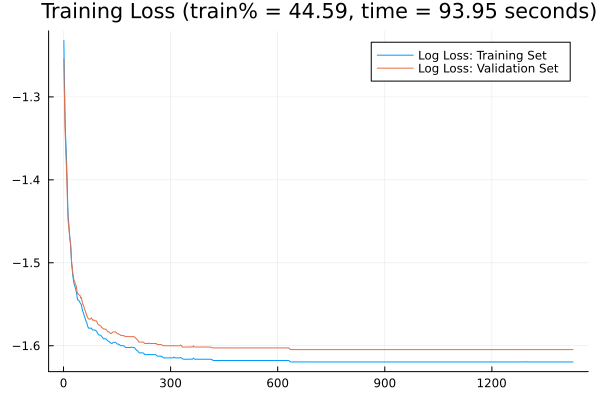

InterruptException()

"Training interupted at epoch 44.0 with a loss of -1.6195339158966677."

In [72]:
t = 1
tstart = time()
iter_max = epochs_max * epoch_length
lt = [log(L(encoder_layers, decoder_layers, data_train))]
lv = [log(L(encoder_layers, decoder_layers, data_test))]
try 
    while lt[end] > laccept && t < iter_max
            telap = (time() - tstart)
            t += 1
            train!(encoder_layers, decoder_layers, P, t; eta=0.001)
            append!(lt, log(L(encoder_layers, decoder_layers, data_train)))
            append!(lv, log(L(encoder_layers, decoder_layers, data_test)))

            p = plot(1:t, [lt lv]; title="Training Loss (train% = $(round(100*t/iter_max, digits=2)), time = $(round(telap, digits=2)) seconds)", label=["Log Loss: Training Set" "Log Loss: Validation Set"])
            IJulia.clear_output(true)
            display(p)
    end
catch y
    display(y)
    display("Training interupted at epoch $(floor(t/epoch_length)) with a loss of $(lt[end]).")
end

,
,
,
,
,
,
,
,
,
,

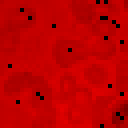
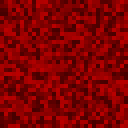
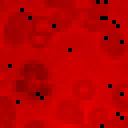
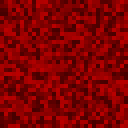
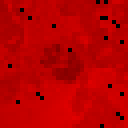
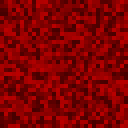
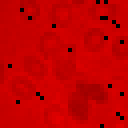
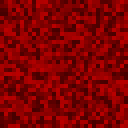
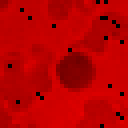
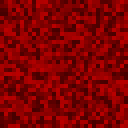
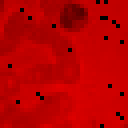
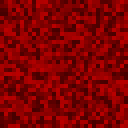
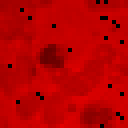
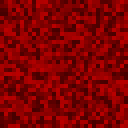
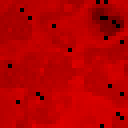
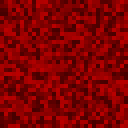
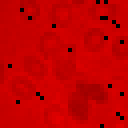
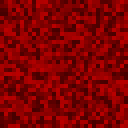
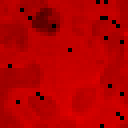
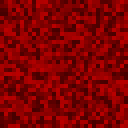

10-element Vector{Bool}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [59]:
data_train[1]
idxs = rand(1:length(data_train), 10)

a = [vectoimg(data_train[i] .* data_range .+ data_min, 32, 32) for i in idxs]
b = [vectoimg(iden(encoder_layers, decoder_layers, data_train[i] .* data_range .+ data_min), 32, 32) for i in idxs]
display(hcat(a,b))
[i == b[1] for i in b]

### 1.2.6 Testing

The final thing we should do is test that our training is not overfitting. There are many different ways that we can validate that the model was a good fit. We will examine our mean square error loss and residuals on our training set. We can also compare the distribution of residuals between the test and training dataset.

In [ ]:
mse_test = []
for i in data_test
    append!(mse_test, L([i]))
end

mse_train = []
for i in data_train
    append!(mse_train, L([i]))
end

using HypothesisTest
println("These distributions have different means at a p-value confidence of $(pvalue(EqualVarianceZTest(mse_test, mse_train)))")
println("These distributions have different variance at a p-value confidence of $(pvalue(VarianceFTest(mse_test, mse_train)))")

ptest = plot(mse_test; st=:histogram, nbins=50, title="Mean Square Error Distributions - Test")
ptrain = plot(mse_train; st=:histogram, nbins=50, title="Mean Square Error Distributions - Train")


The hypothesis tests have quite high p-values and we cannot say that the differences between them are unlikely to come from random chance. We therefore do not reject the null hypothesis that the means and variances are equal and presume them to be from the same distribution. The visual analysis of the distribution confirms that the MSE is roughly uniformly distributed as expected. We therefore conclude that our model is a good fit to the data.

## 1.3 Latent Space and Generation

The encoder transforms the data into a *latent space* which can be exteremely informative. In fact, many autoencoders are trained to precisely interact with the latent space. The first and most straightforward way to think about it is a transformation of a distribution: a random variable is pushed through a forward mapping.

One way in which this can be applied is to make the decoder a generator. If we consider our data to be some random variable $X \tilder \text{Dist}$, then our latent space is a random variable $Z \tilder \text{encoder}(X)$. By sampling randomly in the latent space we can use the *decoder* to generate a random sample of the original distribution. This can be very helpful to generate pseudo-data where data collection is expensive.

# z_samples = [rand()]